# Emperically Estimate: Hetro GP

When the outcome of an action is stocastic, can we using GP, figure out its randomness.

## Synthetic Example: Single Basin with Stocastic Inflows

In [144]:
import baestorm
import GPy
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswmm_lite import environment
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

### Generate Inflows

Inflows to the system are gaussian, with variance between 1.0-3.0 at 0.0 mean. 

In [2]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [58]:
means = [0.0]
sigma = np.linspace(0.40, 5.0, 10)
scale = 10.0

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

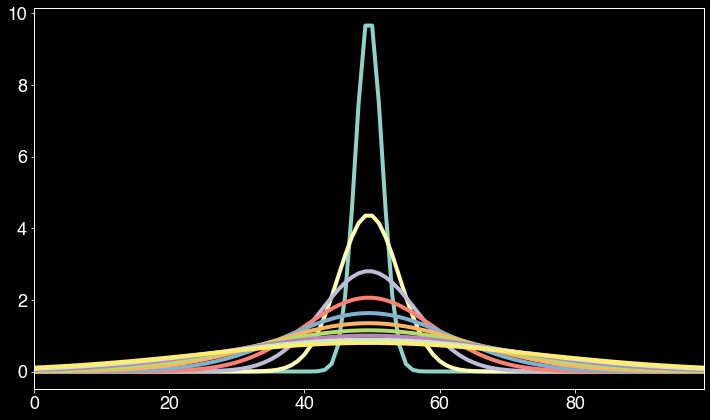

In [362]:
inflows.plot(legend=False)

### Basin Response:

Observe the basin response and find a appropriate threshold.

In [60]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"])

In [61]:
data_flows = {}
for i in inflows.keys():
    flows, _  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

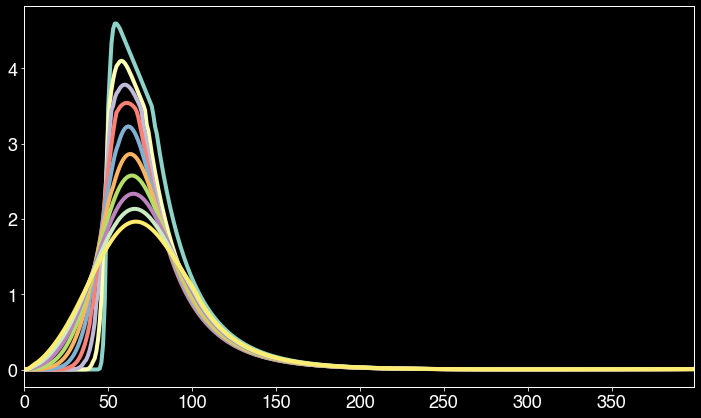

In [363]:
data_flows.plot(legend=False)

Looks like 0.60 might be a decent threshold.

### Design the objective function

In [63]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 9, 10, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows = single_basin(valves, inflows[str(temp_1)].values)
    # Convert to pandas series for ease of ops
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    # Compute performance
    reward = 0.0
    overflows = overflows.gt(0.0).any()
    # Easire reward 
    if overflows:
        reward += 10**3
    flows = flows.sub(0.60)
    flows[flows < 0.0] = 0.0
    reward += flows.sum()
    return reward

#### Check the objective function

Take an action for 20 times and look at the response.

In [64]:
actions = np.linspace(0.0, 1.0, 10)
reward = np.zeros((20, 10))
for action in range(0, 10):
    for rainevent in range(0, 20):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

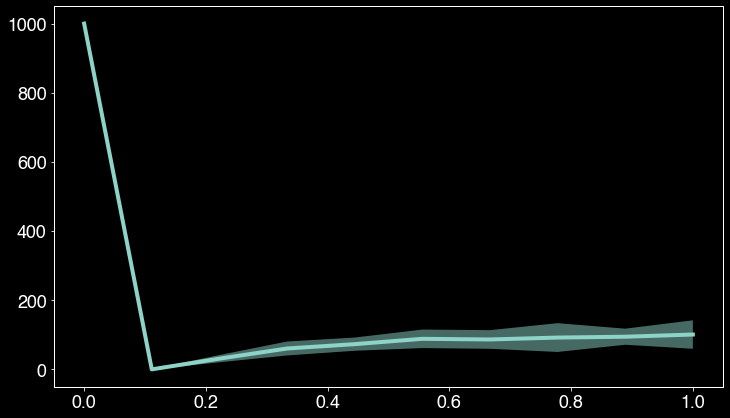

In [153]:
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)

Looks convex enough. 

## Generate data for GP using random sampling

In [182]:
x = []
y = []
for i in range(0, 300):
    x_t = np.array(np.random.rand()) # random action between 0 to 1
    y_t = objective_function(x_t.reshape(-1,1))
    x.append(x_t)
    y.append(y_t)

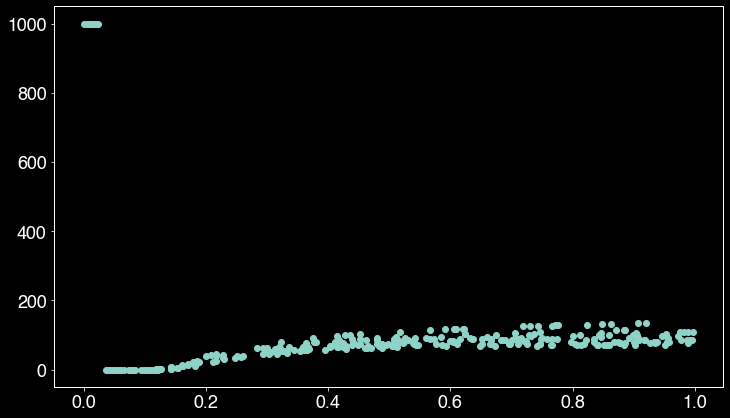

In [183]:
plt.plot(x, y, 'o')

### Normalize the data so that we dont end up with weird things

In [184]:
y = np.array(y)
x = np.array(x)

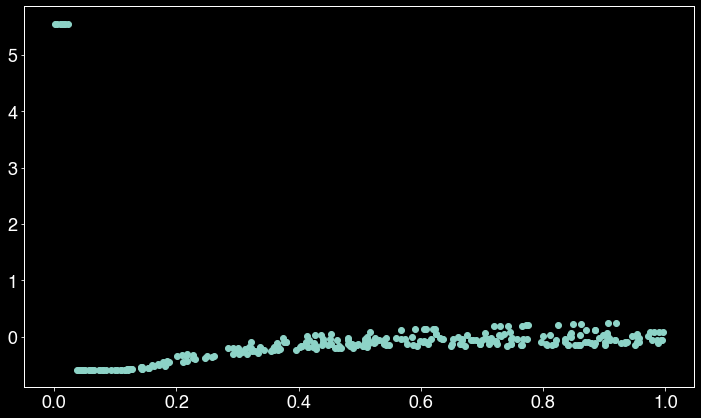

In [185]:
y = (y - y.mean())/y.std()
plt.plot(x, y, 'o')

## Gaussian Processes

Lets train GP to learn on this data

Optimization restart 1/10, f = -56.45171702287527
Optimization restart 2/10, f = -56.45171702287956
Optimization restart 3/10, f = -56.451717022849664
Optimization restart 4/10, f = -56.451717022736716
Optimization restart 5/10, f = -56.45171702288019
Optimization restart 6/10, f = -56.451717020981164
Optimization restart 7/10, f = -56.45171702212468
Optimization restart 8/10, f = -56.45171702267089
Optimization restart 9/10, f = -56.45171702287905
Optimization restart 10/10, f = -56.45171702285526


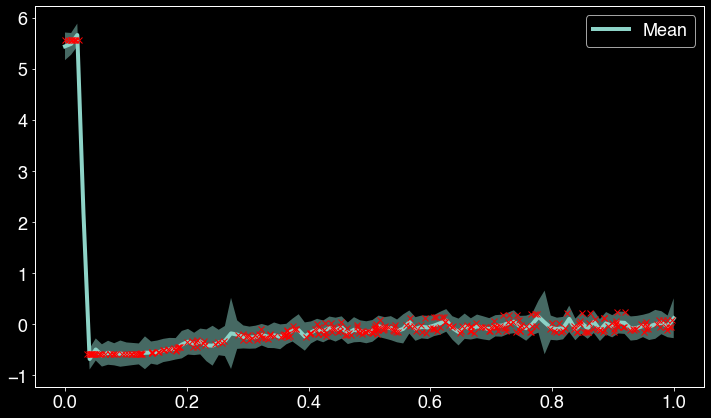

In [359]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)
# Plot error bounds
x_test = np.linspace(0.0,1.0, 100)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
plt.legend()
plt.plot(x,y,'x',color='red')

In [ ]:
plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
plt.legend()

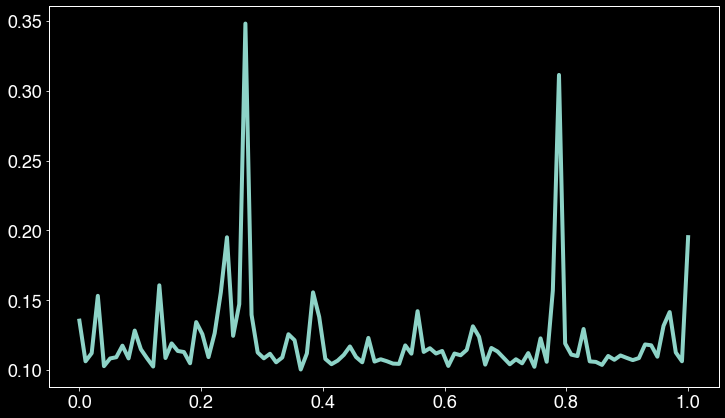

In [187]:
plt.plot(x_test, np.sqrt(v))

Mean looks right, but the variance is over estimated.

## Hetro GP

In [299]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = -56.45171702287527
Optimization restart 2/5, f = -56.45171702287968
Optimization restart 3/5, f = -56.45171702287962
Optimization restart 4/5, f = -56.45171702273768
Optimization restart 5/5, f = -56.451717022816354


In [328]:
m, v = gp1.predict(x.reshape(-1,1))
s = 25
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)
mean_z = z.mean()
std_z = z.std()

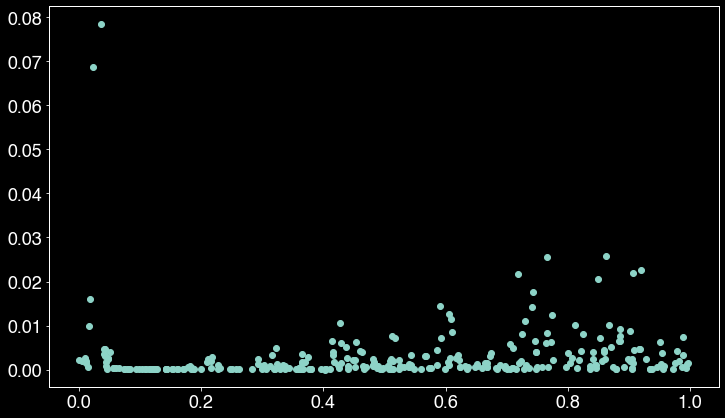

In [369]:
plt.plot(x, (variance_noise), 'o')
z = (z-mean_z)/std_z

In [366]:
kernel2 = GPy.kern.RBF(input_dim=1) #+ GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/10, f = 382.73744016619804
Optimization restart 2/10, f = 382.73744016622226
Optimization restart 3/10, f = 382.73744016637346
Optimization restart 4/10, f = 382.7374401669439
Optimization restart 5/10, f = 382.73744016698527
Optimization restart 6/10, f = 382.7374401865444
Optimization restart 7/10, f = 382.7374401663708
Optimization restart 8/10, f = 382.73744017061165
Optimization restart 9/10, f = 382.73744016623175
Optimization restart 10/10, f = 382.7374401662138


In [367]:
kernel2

rbf.,value,constraints,priors
variance,0.33471972996185,+ve,
lengthscale,0.03807651998665261,+ve,


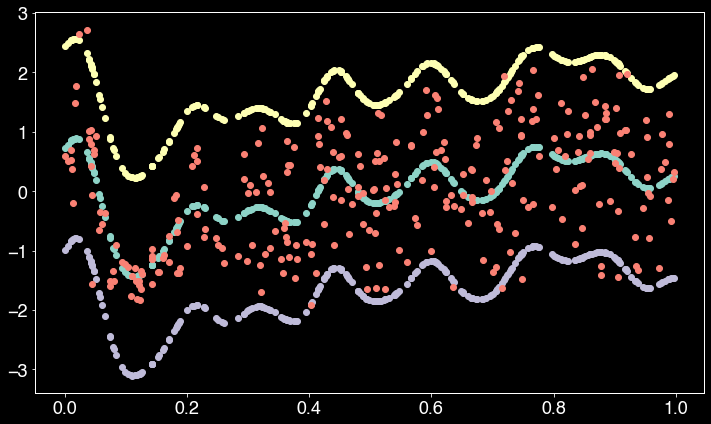

In [368]:
plt.plot(x, m_n, 'o')
up = m_n.reshape(-1) + 2.0*np.sqrt(v_n.reshape(-1))
dwn = m_n.reshape(-1) - 2.0*np.sqrt(v_n.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, (z), 'o')

In [350]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)
#kernel3.parts[0].variance = kernel1.parts[0].variance
#kernel3.parts[0].lengthscale = kernel1.parts[0].lengthscale
#

Optimization restart 1/10, f = -636.3427613419296
Optimization restart 2/10, f = -588.0723497363437
Optimization restart 3/10, f = -624.9335585276442
Optimization restart 4/10, f = -648.3391650991873
Optimization restart 5/10, f = -497.6440819052543
Optimization restart 6/10, f = -596.3140996038037
Optimization restart 7/10, f = -500.5279712491738
Optimization restart 8/10, f = -357.34455501506125
Optimization restart 9/10, f = -591.3408221893965
Optimization restart 10/10, f = -506.36387714031395


In [351]:
kernel3.parts[1].variance = np.exp(m_n * std_z + mean_z).reshape(x.shape[0])

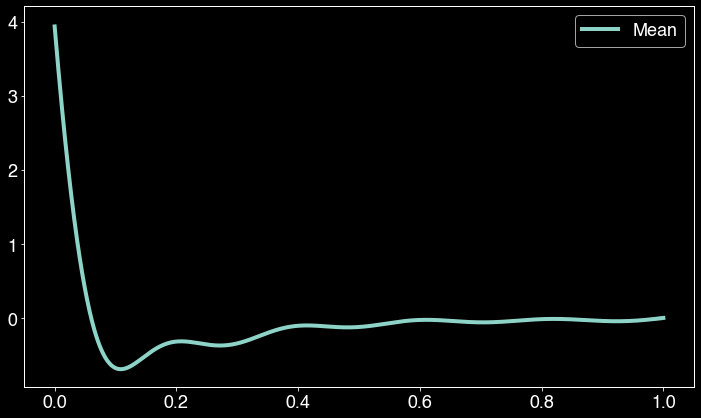

In [353]:
x_test=np.linspace(0,1,1000)
m, v = gp3.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(x_test, up, dwn, alpha=0.5)
plt.plot(x_test, m, label="Mean")
#plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

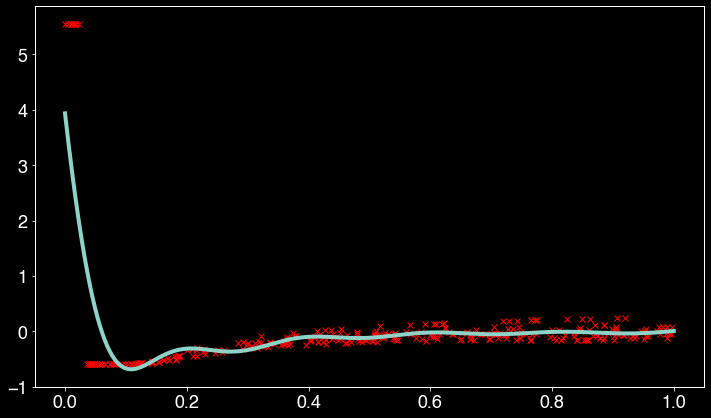

In [354]:
plt.plot(x,y,'x',color='red')
plt.fill_between(x_test, up, dwn, alpha=0.7)
plt.plot(x_test, m, label="Mean")

In [287]:
gp1 = copy.deepcopy(gp3)

Here is the tricky part. Noise is dependent on action. But it is not exactly dependent on just the action, hence the difference between 0.5 to 0.6 (two valve positions) might not be the variables to map noise. We might be better of estimating the noise using a common one.

## Noise dependency

May be we try it with two variables, one with action and one with which rainfall us used, then learn the mapping between both and noise.